## Начальная настройка

In [ ]:
!pip install -q pandas==1.5.3
!pip install -q gretel-synthetics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 16.6 MB/s eta 0:00:

In [ ]:
!sed -i 's/base_matrix = np.eye(N=len(index), dtype=np.int)/base_matrix = np.eye(N=len(index), dtype=np.int32)/g' /usr/local/lib/python3.10/dist-packages/category_encoders/one_hot.py

In [ ]:
!wget -q https://raw.githubusercontent.com/sswt/dive2gai/w14/unit14/dgan.py
!cp dgan.py /usr/local/lib/python3.10/dist-packages/gretel_synthetics/timeseries_dgan/dgan.py

#### NOTE

gretel_synthetics/timeseries_dgan/dgan.py was monkey patched to add losses

```
309,310c309
<         losses = self._train(dataset, progress_callback=progress_callback)
<         return losses
---
>         self._train(dataset, progress_callback=progress_callback)
396c395
<         losses = self.train_numpy(
---
>         self.train_numpy(
403d401
<         return losses
692d689
<         losses = {'D': [], 'D_attr': [], 'G': []}
738,739d734
<                     losses['D'].append([x.detach().item()
<                                         for x in [loss_generated, loss_real, loss_gradient_penalty]])
771,772d765
<                         losses['D_attr'].append([x.detach().item()
<                                                  for x in [loss_generated, loss_real, loss_gradient_penalty]])
799d791
<                     losses['G'].append(loss.detach().item())
813d804
<         return losses
```

## Основная часть

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig

## Загрузка данных

Данные представляют лог действий пользователей на популярной MOOC-площадке, с  временной меткой, категориальным и числовыми атрибутами. Есть также переменная LABEL, которая представляет собой бинарный флаг - бросил ли пользователь курс после этого действия, то есть было ли это действие последним для пользователя.

In [ ]:
!wget -q https://huggingface.co/datasets/sswt/stanford-act-mooc/resolve/main/act-mooc.csv.gz

In [ ]:
df = pd.read_csv('act-mooc.csv.gz')
print(df.shape)
df = df.drop_duplicates()
print(df.shape)
df.head()

(411749, 9)
(396712, 9)


,ACTIONID,USERID,TARGETID,TIMESTAMP,FEATURE0,FEATURE1,FEATURE2,FEATURE3,LABEL
0,0,0,0,0.0,-0.319991,-0.435701,0.106784,-0.067309,0
1,1,0,1,6.0,-0.319991,-0.435701,0.106784,-0.067309,0
2,2,0,2,41.0,-0.319991,-0.435701,0.106784,-0.067309,0
3,3,0,1,49.0,-0.319991,-0.435701,0.106784,-0.067309,0
4,4,0,2,51.0,-0.319991,-0.435701,0.106784,-0.067309,0


In [ ]:
del df['ACTIONID']
df.sort_values(['USERID', 'TIMESTAMP', 'LABEL'], inplace=True)

## Разбиение и предобработка данных

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_ix, test_ix = next(gss.split(df, groups=df['USERID']))
df_train = df.iloc[train_ix].copy()
df_test = df.iloc[test_ix].copy()
df_train.shape, df_test.shape

((271341, 8), (125371, 8))

In [ ]:
max_seq_len = (int(df_train['USERID'].value_counts().describe(percentiles=[.95])['95%']) // 5) * 5
print(f'95th percentile of len: {max_seq_len}')

95th percentile of len: 165


In [ ]:
df_train['row_num'] = df_train.groupby('USERID').cumcount()
df_train = df_train[df_train['row_num'] < max_seq_len].copy()
df_train.shape

(260757, 9)

In [ ]:
df_align = pd.DataFrame({'USERID': s, 'row_num': i} for s in df_train['USERID'].unique()
                        for i in range(max_seq_len))
df_align.shape

(813780, 2)

In [ ]:
df_train = df_train.merge(df_align, how='right').fillna(0)
del df_train['row_num']
df_train.shape

(813780, 8)

## Обучение генеративной модели

In [ ]:
def print_progress(p):
    # ProgressInfo(epoch=0, total_epochs=100, batch=0, total_batches=50)
    # Loop runs over batch in total_batches
    print(f'\r{p.frac_completed:.1%}', end='')

In [ ]:
config = DGANConfig(
     max_sequence_len=max_seq_len,
     sample_len=5,
     batch_size=200,
     discriminator_rounds=1,
     epochs=1000
)
model = DGAN(config)

In [ ]:
discrete_columns = ['TARGETID', 'LABEL']
feature_columns = ['TARGETID', 'TIMESTAMP', 'FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3', 'LABEL']
losses = model.train_dataframe(df_train, example_id_column='USERID', df_style='long',
                               discrete_columns=discrete_columns, progress_callback=print_progress)

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.10/dist-packages/category_encoders/one_hot.py:187: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.10/dist-packages/category_encoders/one_hot.py:187: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.f

100.1%


---



In [ ]:
df_syn = model.generate_dataframe(df_train.USERID.nunique())
df_syn.shape, df_train.shape

((813780, 8), (813780, 8))

In [ ]:
df_syn

,USERID,TARGETID,TIMESTAMP,FEATURE0,FEATURE1,FEATURE2,FEATURE3,LABEL
0,0,1,2087902.375,-0.634301,0.489527,-0.390502,0.052007,0
1,0,1,2092796.875,-0.628518,0.490178,-0.390470,0.052008,0
2,0,1,2096137.750,-0.629298,0.499748,-0.390386,0.052007,0
3,0,3,2101048.000,-0.625749,0.520689,-0.390456,0.052007,0
4,0,3,2101628.000,-0.628287,0.514646,-0.390462,0.052007,0
...,...,...,...,...,...,...,...,...
813775,4931,0,2231662.250,3.280563,1.610379,-0.383019,-0.047509,0
813776,4931,0,2231648.750,3.281306,1.609888,-0.383008,-0.047509,0
813777,4931,0,2231637.000,3.279804,1.616071,-0.382724,-0.047509,0
813778,4931,0,2231632.000,3.281404,1.619665,-0.384768,-0.047509,0


### Распределение атрибутов

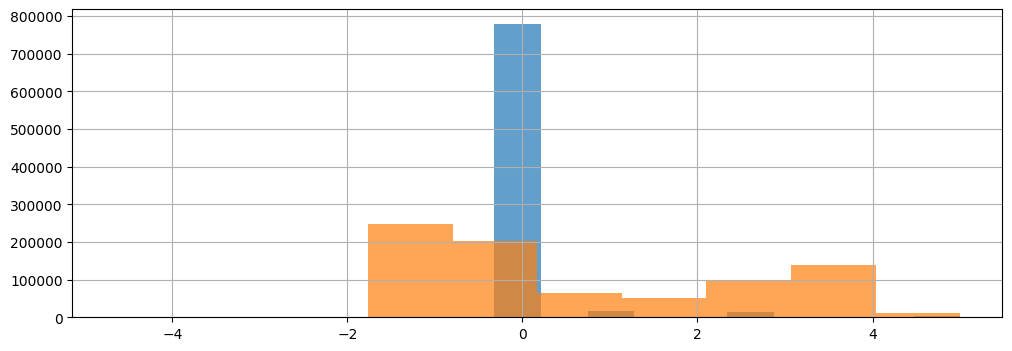

In [ ]:
df_train['FEATURE0'].clip(upper=5).hist(figsize=(12, 4), alpha=.7)
df_syn['FEATURE0'].clip(upper=5).hist(alpha=.7);

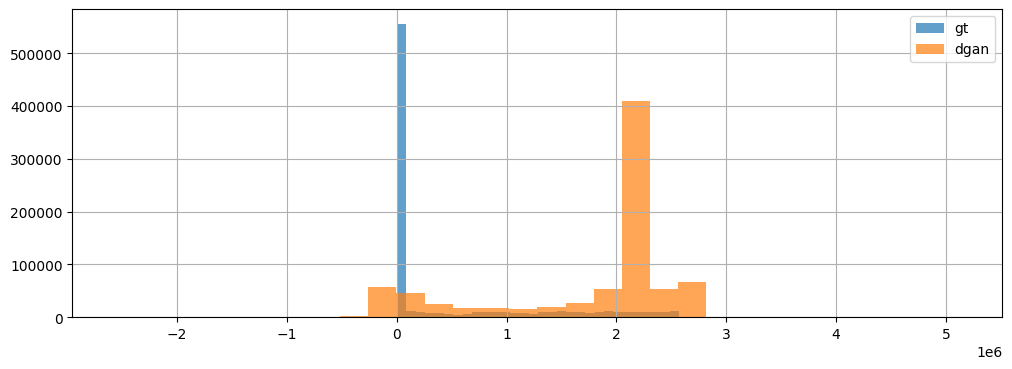

In [ ]:
df_train['TIMESTAMP'].hist(figsize=(12, 4), alpha=.7, bins=30)
df_syn['TIMESTAMP'].hist(alpha=.7, bins=30)
plt.legend(['gt', 'dgan'])

In [ ]:
col = 'LABEL'
pd.concat([
    df_train[col].value_counts().rename('Real'),
    df_syn[col].value_counts().rename('DGAN')
], axis=1)

,Real,DGAN
0.0,810932,812382
1.0,2848,1398


### Функции потерь

In [ ]:
losses['D'] = np.array(losses['D'])
losses['D_attr'] = np.array(losses['D_attr'])

In [ ]:
loss_names = ['Generated', 'Real', 'Gradient Penalty']

In [ ]:
loss_names = ['Discr generated', 'Discr real', 'Discr gradient penalty']

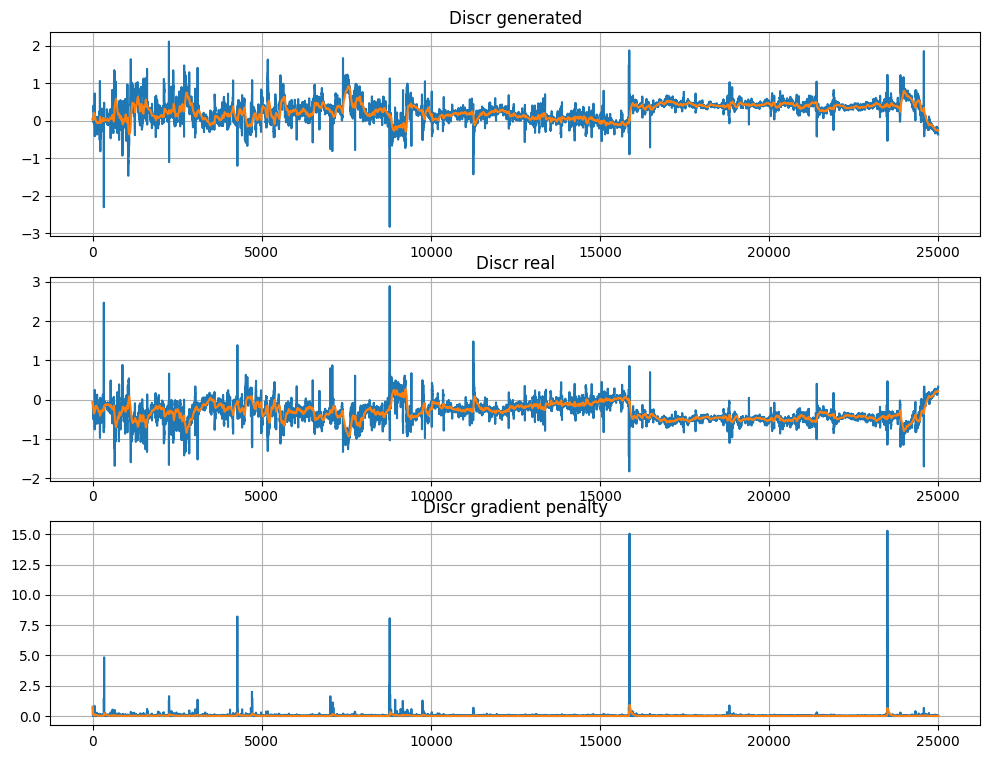

In [ ]:
fig, axes = plt.subplots(3, figsize=(12, 9))
for i, ax in enumerate(axes):
    ax.plot(losses['D'][:, i])
    pd.Series(losses['D'][:, i]).ewm(span=100).mean().plot(ax=ax, grid=True)
    ax.set_title(loss_names[i])

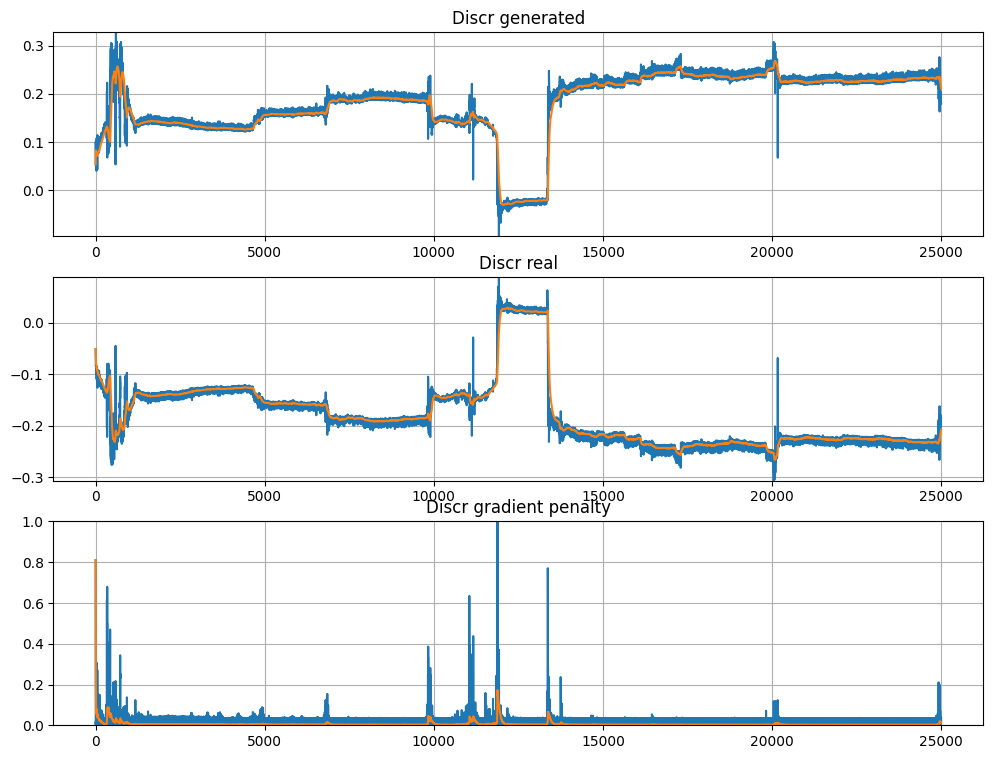

In [ ]:
fig, axes = plt.subplots(3, figsize=(12, 9))
for i, ax in enumerate(axes):
    ax.plot(losses['D_attr'][:, i])
    pd.Series(losses['D_attr'][:, i]).ewm(span=100).mean().plot(ax=ax, grid=True)
    ax.set_ylim(bottom=min(losses['D_attr'][:, i].min(), 0), top=min(losses['D_attr'][:, i].max(), 1))
    ax.set_title(loss_names[i])

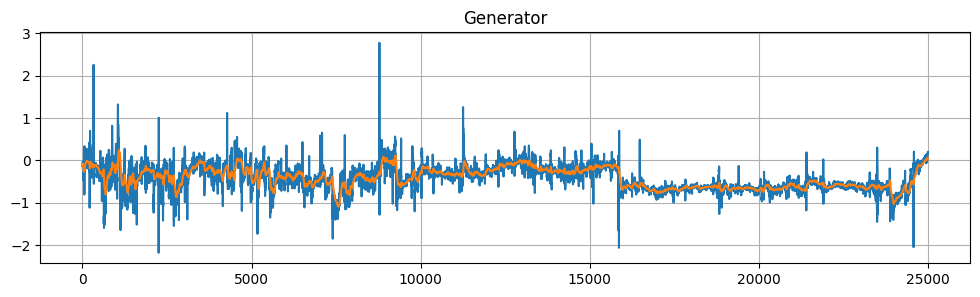

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(losses['G'])
pd.Series(losses['G']).ewm(span=100).mean().plot(ax=ax, grid=True)
ax.set_title('Generator');

## TSTR валидация

In [ ]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

def get_features(df):
    agg_dict = {
        'LABEL': ('LABEL', 'max'),
        'cnt': ('LABEL', 'count'),
        'min_ts': ('TIMESTAMP', 'min'),
        'max_ts': ('TIMESTAMP', 'max')
    }
    agg_dict.update({f'mean_{c}': (c, 'mean')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    agg_dict.update({f'max_{c}': (c, 'max')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    df_agg = df.groupby('USERID').agg(**agg_dict).reset_index()
    df_agg['dur'] = df_agg['max_ts'] - df_agg['min_ts']
    del df_agg['max_ts'], df_agg['min_ts']
    return df_agg

def eval_model(df_train, df_test, mode):
    X_train = df_train.copy()
    y_train = X_train.pop('LABEL')
    X_test = df_test.copy()
    y_test = X_test.pop('LABEL')
    xgb = XGBClassifier(n_estimators=30, max_depth=5, learning_rate=.1, objective='binary:logistic', verbosity=1)
    xgb.fit(X_train, y_train)
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    metrics = {'mode': mode,
               'cnt_rows_train': y_train.shape[0],
               'cnt_ones_train': (y_train == 1).sum(),
               'F1_train': f1_score(y_train, y_pred_train),
               'F1_test': f1_score(y_test, y_pred_test)}
    return metrics

In [ ]:
df_train_feat = get_features(df_train)
df_test_feat = get_features(df_test)
df_dgan_feat = get_features(df_syn)
df_train_feat.shape, df_test_feat.shape, df_dgan_feat.shape

((4932, 12), (2115, 12), (4932, 12))

In [ ]:
df_eval = pd.DataFrame([
    eval_model(df_dgan_feat, df_test_feat, 'TSTR DGAN'),
    eval_model(df_train_feat, df_test_feat, 'TRTR')
])
df_eval

,mode,cnt_rows_train,cnt_ones_train,F1_train,F1_test
0,TSTR DGAN,4932,875,0.577778,0.014839
1,TRTR,4932,2848,0.853470,0.526857
